In [451]:
import warnings
warnings.filterwarnings("ignore")

import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [422]:
img_1 = cv2.imread('./image pairs/image pairs_04_01.jpg')
img_2= cv2.imread('./image pairs/image pairs_04_02.jpg')

In [423]:
# Convert to grayscale
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

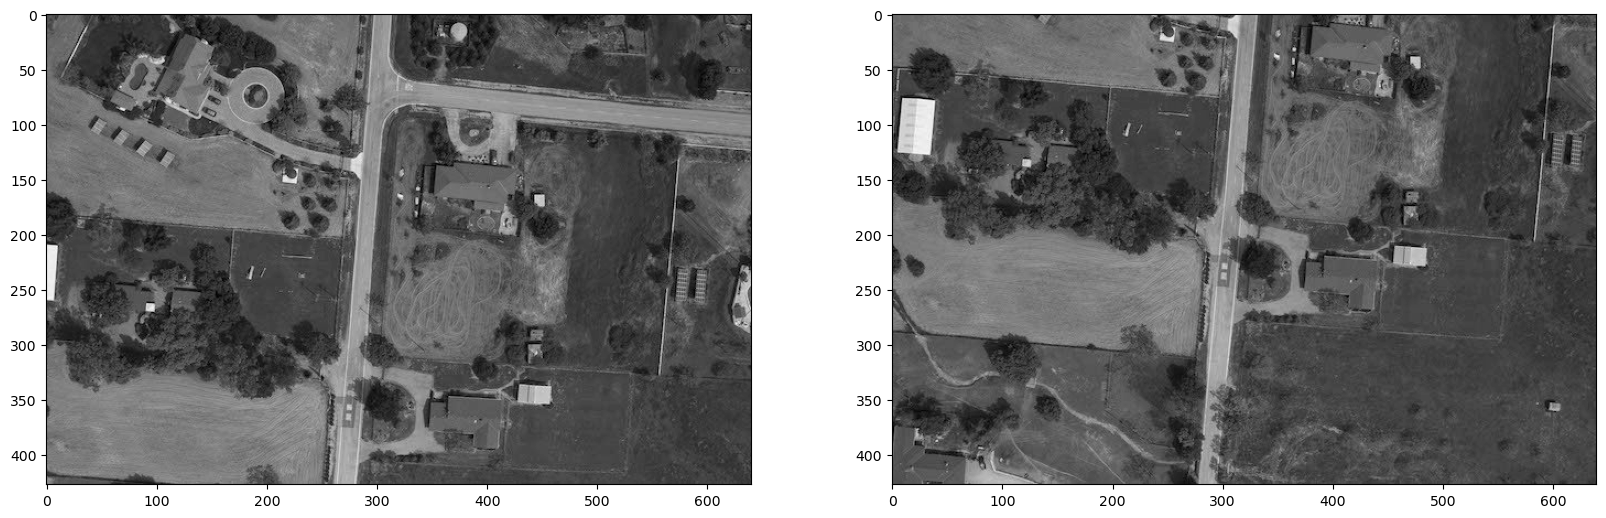

In [52]:
# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].imshow(img_1_gray, cmap='gray')
plots[1].imshow(img_2_gray, cmap='gray')

plt.show()

### Scale Space Extrema Detection

#### Generate Image Pyramid

In [5]:
img = img_1_gray

In [6]:
def quick_resize(img, scale_percent):
    
    # scale_percent - percent of the original image's scale
    
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    return resized

In [137]:
num_octaves = 4

img_pyramid = []
imgs_scaled = img

for i in range(num_octaves):
    
    # Gaussian Operator parameters
    num_intervals = 5
    step_size = 1
    sigmas = np.arange(1, step_size * (num_intervals + 1), step_size)

    # Create a list of gaussian blurs using different values of sigma parameter
    gaussian_images = []
    for sigma in sigmas:
        gaussian_images.append(cv2.GaussianBlur(imgs_scaled, (0,0), sigma, cv2.BORDER_DEFAULT))
        
    # Append each list of gaussian images to the main img_pyramid list
    img_pyramid.append(gaussian_images)
    
    # Scale down image by half the original size
    imgs_scaled = quick_resize(imgs_scaled, 50)

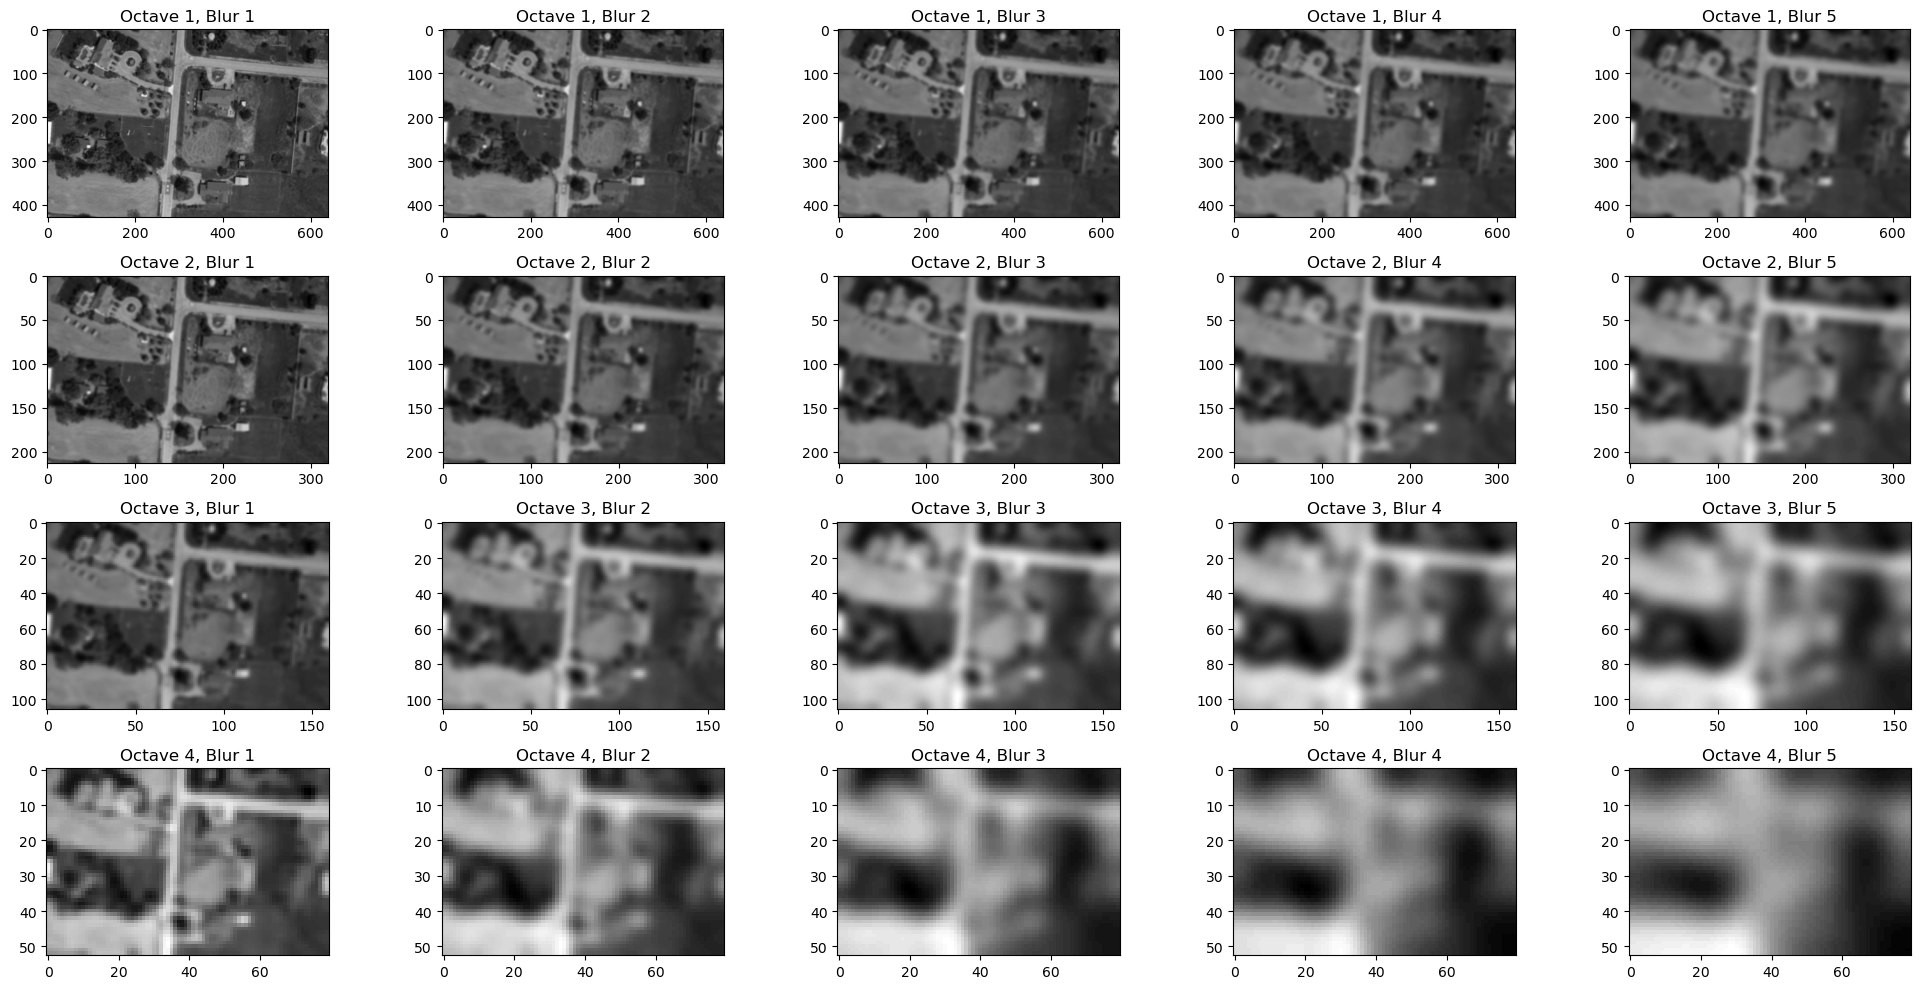

In [138]:
num_blurs = len(img_pyramid[0])
num_octaves = len(img_pyramid)

fig, ax = plt.subplots(num_octaves, num_blurs, figsize=(4 * num_blurs, 2.5 * num_octaves))

for i in range(num_octaves):
    for j in range(num_blurs):
        ax[i,j].imshow(img_pyramid[i][j], cmap='gray')
        ax[i,j].set_title(f'Octave {i+1}, Blur {j+1}')

plt.tight_layout()

#### Calculate Difference of Gradients (DoG)

In [166]:
DoG = []

for i in range(num_octaves):
    
    DoG_row = []
    for j in range(num_blurs - 1):
        DoG_row.append(img_pyramid[i][j+1] - img_pyramid[i][j])
        
    DoG.append(DoG_row)

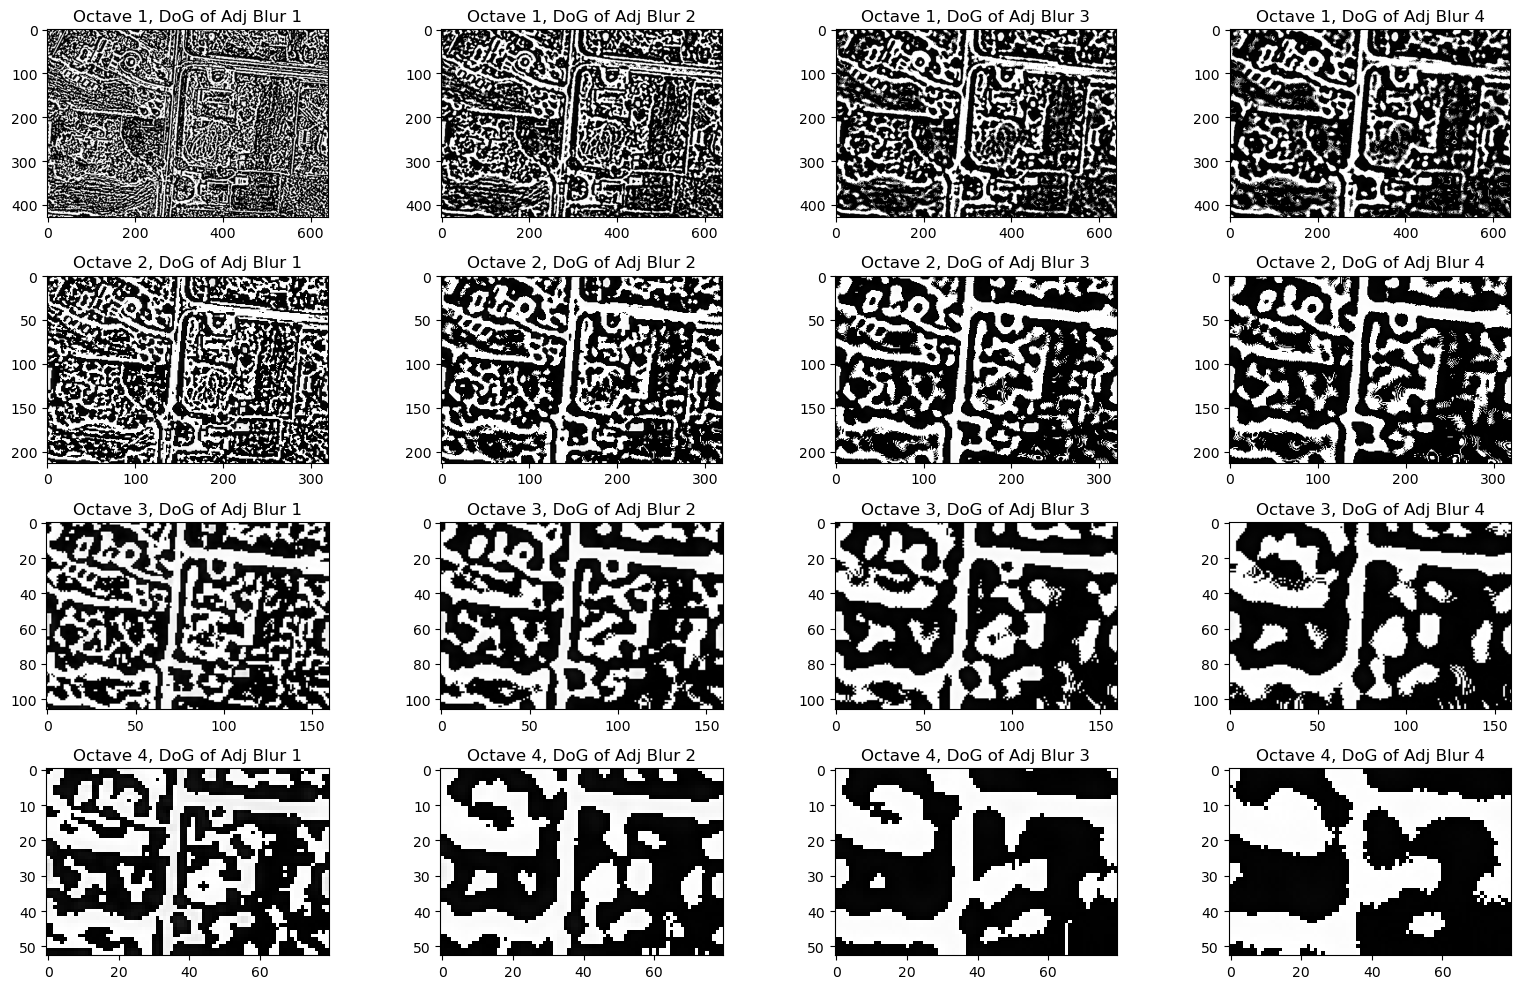

In [167]:
num_cols = len(DoG[0])
num_rows = len(DoG)

fig, ax = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 2.5 * num_rows))

for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].imshow(DoG[i][j], cmap='gray')
        ax[i,j].set_title(f'Octave {i+1}, DoG of Adj Blur {j+1}')

plt.tight_layout()

#### Keypoint Localization

In [389]:
def get_region_of_interest(octave, octave_index, pixel_coordinates, PRINT_INFO = False):
    
    pixel_row_index, pixel_col_index = pixel_coordinates

    row_lower_bound = max(0,pixel_row_index - 1)
    row_upper_bound = pixel_row_index + 2
    col_lower_bound = max(0,pixel_col_index - 1)
    col_upper_bound = pixel_col_index + 2

    # If current octave is the top-most of the octave stack
    if octave_index == 0:
        prev_octave = np.array([])
    else:
        prev_octave = octave[octave_index - 1][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    # If the current octave is at bottom-most of the octave stack
    if octave_index == len(octave) - 1:
        next_octave = np.array([])
    else:
        next_octave = octave[octave_index + 1][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    curr_octave = octave[octave_index][row_lower_bound : row_upper_bound, col_lower_bound : col_upper_bound]

    if PRINT_INFO:
        print(f'Previous Octave:\n {prev_octave}\n')
        print(f'Current Octave:\n {curr_octave}\n')
        print(f'Next Octave:\n {next_octave}')
        
    return prev_octave.tolist(), curr_octave.tolist(), next_octave.tolist()

In [390]:
def is_center_pixel_extremum(pixel_value, prev_octave, curr_octave, next_octave):
    
    region_of_interest = prev_octave + curr_octave + next_octave

    region_of_interest_flatten = [item for sublist in region_of_interest for item in sublist]

    is_extremum = any(pixel_value == [max(region_of_interest_flatten), min(region_of_interest_flatten)]) and (sum(pixel_value == region_of_interest_flatten) == 1)
    
    return is_extremum

In [391]:
# Sample DoG list of images for testing purposes
sample_octave = np.array([[[7, 4, 2, 3], 
                           [3, 11, 0, 2], 
                           [2, 8, 5, 5]], 
                          
                          [[8, 2, 5, 5], 
                           [3, 0, 9, 7], 
                           [4, 3, 3, 8]],
                          
                          [[2, 7, 1, 9], 
                           [5, 4, 8, 9], 
                           [6, 3, 5, 2]]])


# TEST get_region_of_interest
sample_octave_index = 2
pixel_coordinates = (2,3)
pixel_value = sample_octave[sample_octave_index][pixel_coordinates]

print(f'Pixel Value: {pixel_value}')

prev_octave_sample, curr_octave_sample, next_octave_sample = get_region_of_interest(sample_octave, sample_octave_index, pixel_coordinates)

print(f'Prev Layer: {prev_octave_sample}')
print(f'Curr Layer: {curr_octave_sample}')
print(f'Next Layer: {next_octave_sample}')

Pixel Value: 2
Prev Layer: [[9, 7], [3, 8]]
Curr Layer: [[8, 9], [5, 2]]
Next Layer: []


In [392]:
# TEST is_center_pixel_extremum
is_center_pixel_extremum(pixel_value, prev_octave_sample, curr_octave_sample, next_octave_sample)

True

##### FOR OBSERVATION PURPOSES: Keypoint Localization for one DoG layer

Text(0.5, 1.0, 'Octave 1, DoG of Adj Blur 3')

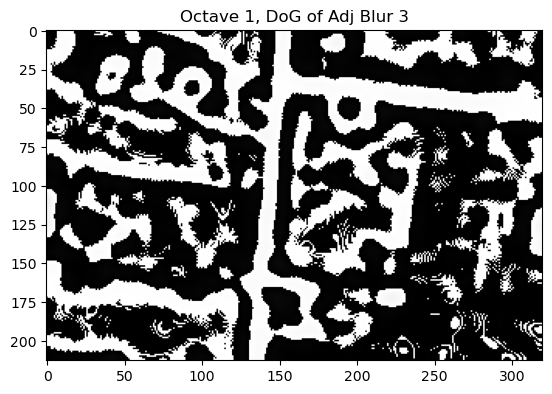

In [437]:
# Generate keypoint for a specific DoG Image
octave_index = 1
DoG_image_index = 3
octave = DoG[octave_index]
DoG_image = octave[DoG_image_index]
plt.imshow(DoG_image,cmap='gray')
plt.title(f'Octave {octave_index}, DoG of Adj Blur {DoG_image_index}')

In [438]:
keypoints = []
for pixel_row_index, image_row in enumerate(DoG_image):
    
    for pixel_col_index, center_pixel_value in enumerate(image_row):
        
        center_pixel_coordinate = (pixel_row_index, pixel_col_index)

        prev_octave, curr_octave, next_octave = get_region_of_interest(octave, octave_index, center_pixel_coordinate, PRINT_INFO = False)

        if is_center_pixel_extremum(center_pixel_value, prev_octave, curr_octave, next_octave):
            
            keypoints.append([octave_index, DoG_image_index, (pixel_row_index, pixel_col_index)])

print(len(keypoints))

1905


Text(0.5, 1.0, 'Keypoints on Original Image, Rescaled')

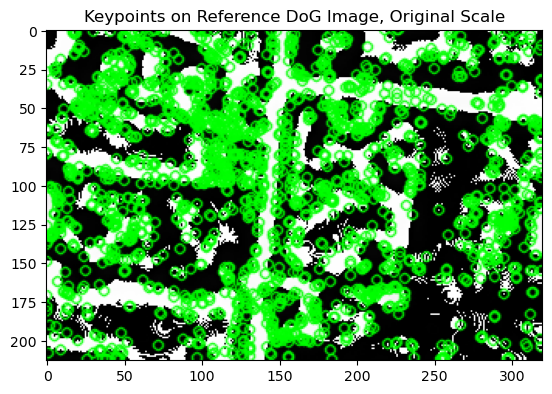

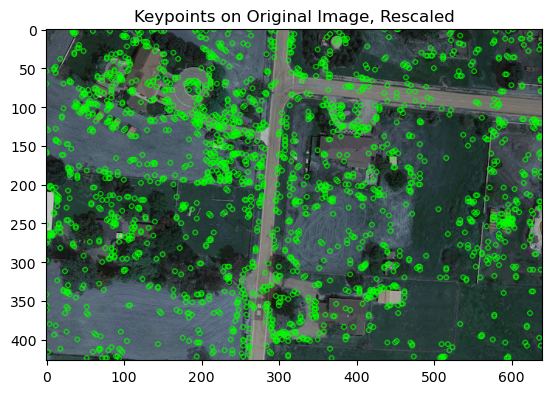

In [439]:
plt.figure()
raw_keypoint_objects = [cv2.KeyPoint(kp_y, kp_x, 1) for _, _, (kp_x, kp_y) in keypoints]
plt.imshow(cv2.drawKeypoints(DoG_image, raw_keypoint_objects,  None, (0, 255, 0)))
plt.title('Keypoints on Reference DoG Image, Original Scale')

plt.figure()
keypoint_objects = [cv2.KeyPoint(kp_y * 2**octave_index, kp_x * 2**octave_index, 1) for octave_index, _, (kp_x, kp_y) in keypoints]
plt.imshow(cv2.drawKeypoints(img_1, keypoint_objects,  None, (0, 255, 0)))
plt.title('Keypoints on Original Image, Rescaled')

##### FOR OBSERVATION PURPOSES: Filter Keypoints on one DoG Image

In [441]:
keypoints_filtered = []
# Set Harris Corner Detection parameters
block_size = 2  # Neighborhood size for corner detection
ksize = 3  # Aperture parameter for Sobel operator
k = 0.04  # Harris corner detection free parameter

# Apply Harris Corner Detection
corners = cv2.cornerHarris(img_1_gray, block_size, ksize, k)

# Threshold for classifying keypoints as edges or flats
threshold = 0.01 * corners.max()

for i, (_, _, kp) in enumerate(keypoints):
    kp_x, kp_y = kp
    
    # Remove Flats
    if corners[kp_x*2**octave_index, kp_y*2**octave_index] > threshold:
        keypoints_filtered.append(keypoints[i])

Text(0.5, 1.0, 'Original Image - Flat Keypoints Removed')

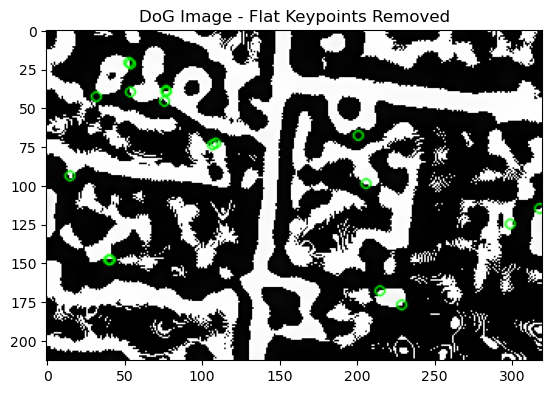

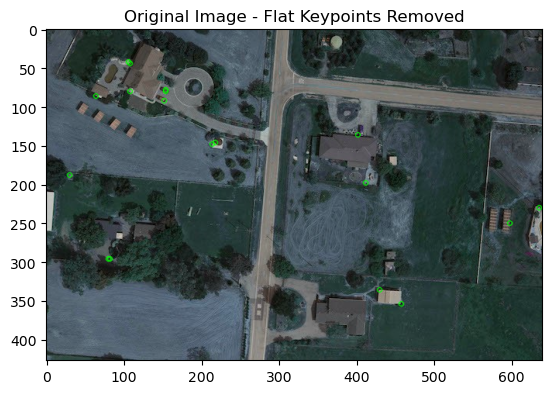

In [442]:
plt.figure()
raw_keypoint_objects = [cv2.KeyPoint(kp_y, kp_x, 1) for _, _, (kp_x, kp_y) in keypoints_filtered]
plt.imshow(cv2.drawKeypoints(DoG_image, raw_keypoint_objects,  None, (0, 255, 0)))
plt.title('DoG Image - Flat Keypoints Removed')

plt.figure()
rescale_factor = 2**octave_index
keypoint_objects = [cv2.KeyPoint(kp_y * rescale_factor, kp_x * rescale_factor, 1) for _, _, (kp_x, kp_y) in keypoints_filtered]
plt.imshow(cv2.drawKeypoints(img_1, keypoint_objects,  None, (0, 255, 0)))
plt.title('Original Image - Flat Keypoints Removed')

#### Keypoint Localization (Across All DoG Layers + Filtering)

In [443]:
# Set Harris Corner Detection parameters
block_size = 2  # Neighborhood size for corner detection
ksize = 3  # Aperture parameter for Sobel operator
k = 0.04  # Harris corner detection free parameter

# Threshold for classifying keypoints as edges or flats
threshold = 0.01 * corners.max()

keypoints = []
for octave_index, octave in enumerate(DoG):
    for DoG_image_index, DoG_image in enumerate(octave):
        for pixel_row_index, image_row in enumerate(DoG_image):

            # Calculate corner coefficient
            corners = cv2.cornerHarris(img_1_gray, block_size, ksize, k)

            for pixel_col_index, center_pixel_value in enumerate(image_row):

                center_pixel_coordinate = (pixel_row_index, pixel_col_index)

                prev_octave, curr_octave, next_octave = get_region_of_interest(octave, octave_index, center_pixel_coordinate, PRINT_INFO = False)

                if is_center_pixel_extremum(center_pixel_value, prev_octave, curr_octave, next_octave):

                    # If extremum detected is not flat
                    if corners[pixel_row_index*2**octave_index, pixel_col_index*2**octave_index] > threshold:
                        keypoints.append([octave_index, DoG_image_index, (pixel_row_index, pixel_col_index)])
print(len(keypoints))

714


Text(0.5, 1.0, 'SIFT Module Feature Detection Output (for Comparison)')

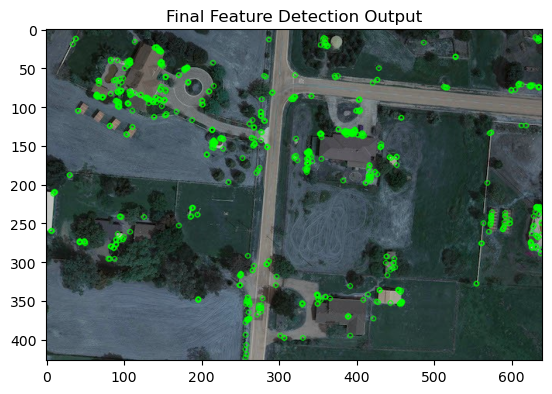

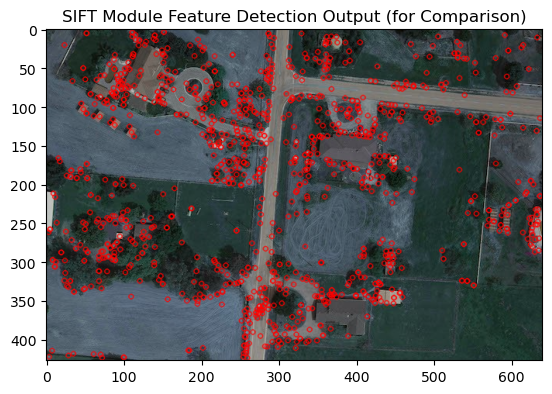

In [450]:
plt.figure()
keypoint_objects = [cv2.KeyPoint(kp_y * 2**octave_index, kp_x * 2**octave_index, 1) for octave_index, _, (kp_x, kp_y) in keypoints]
plt.imshow(cv2.drawKeypoints(img_1, keypoint_objects,  None, (0, 255, 0)))
plt.title('Final Feature Detection Output')

plt.figure()
sift = cv2.SIFT_create()
kp_ = sift.detect(img_1_gray,None)
plt.imshow(cv2.drawKeypoints(img_1, kp_,  None, (255, 0, 0)))
plt.title('SIFT Module Feature Detection Output (for Comparison)')